# Random Fourier Features

## Motivation
The sparse GP allows us to perform inference for a much smaller cost in time and memory. However, as we showed in the previous notebook, although we can fit the GP over a large dataset, we cannot sample the GP across the entire input space because we simply do not have the available memory to load the covariance matrix. A solution to this is to approximate the best-fit GP with Random Fourier Features (see [Appendix A](#appendix-a-random-fourier-features-for-sparse-gp-sampling) for more details).



In [1]:
# necessary packages
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl
from tqdm import tqdm

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax.scipy.special import logit, expit
from jax import jit

from tinygp import GaussianProcess, kernels
import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Repeat 2D Poisson Data Fit from Previous Notebook with Fixed Inducing Points

Text(0.5, 1.0, 'True Rate')

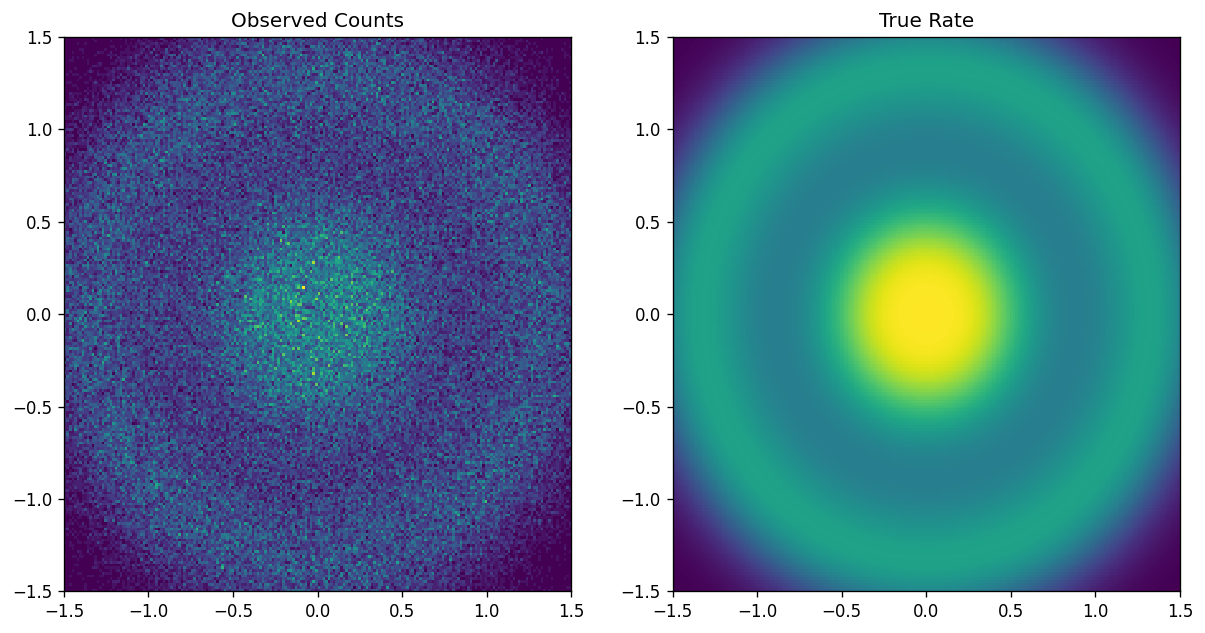

In [2]:
# plot the true function
x1_plt = jnp.linspace(-1.5, 1.5, 201)
x2_plt = jnp.linspace(-1.5, 1.5, 201)
x1_c = 0.5 * (x1_plt[1:] + x1_plt[:-1]) ; x2_c = 0.5 * (x2_plt[1:] + x2_plt[:-1])
x1, x2 = jnp.meshgrid(x1_c, x2_c)
x = jnp.stack([x1, x2], axis=-1)
x_mag = jnp.linalg.norm(x, axis = -1)
log_rate = -0.6 * x_mag**2. * jnp.abs(1.5 + jnp.cos(8. * x_mag**(0.5)))
rate = 10 * jnp.exp(log_rate)
y = rate

# add poisson noise
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y) 

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)
ax.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis')
ax.set_title('Observed Counts')

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')

In [3]:
# for defining a 2D Gaussian Process, need to reshape data into 1D arrays
# KEY: shape must be of the form (N_data, ) NOT (N_data) or (N_data, 1))   
x_f = x.reshape((-1,2))
y_obs_f = y_obs.reshape((-1,))

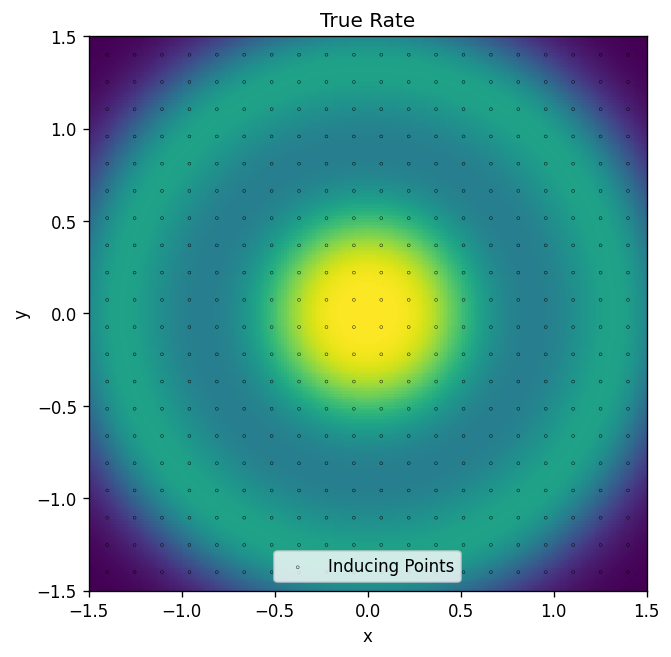

In [4]:
# create mesh grid of x and y inducing point locations
xu1_plt = np.linspace(-1.4, 1.4, 20) ; xu2_plt = np.linspace(-1.4, 1.4, 20)
xu1, xu2 = jnp.meshgrid(xu1_plt, xu2_plt)
xu = jnp.stack([xu1, xu2], axis=-1)
xu_f = xu.reshape((-1,2))

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

ax.pcolormesh(x1_plt, x2_plt, rate, cmap='viridis')
ax.set_title('True Rate')
ax.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25, label = 'Inducing Points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

In [5]:
def model(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)  ; shape: (Nx, Ndim)
    xu : array
        x values of inducing points ; shape: (Nu, Ndim)
    y : array
        y values (observations) ; shape: (Nx, )
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples with subsampling
    with numpyro.plate('data', size=len(x), dim=-1, subsample_size=512) as ind:
        _, gp_x = gp_u.condition(log_rate_u, x[ind], diag=1e-3)
        log_rate = gp_x.sample(key = gp_rng_key)
        rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y[ind])) 

In [6]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.005, num_particles = 8)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 20000, svi, x_f, xu_f, y_obs_f)

100%|██████████| 20000/20000 [02:23<00:00, 138.97it/s]


## Crude RFF Sampler and Pathwise Conditioning of Sparse GP Posterior with RFF Approximation
Adapted from https://random-walks.org/book/papers/rff/rff.html for JAX. We sequentially generate $f$-samples from $u$. A vectorized sampler may be much faster.

In [7]:
from functools import partial
@partial(jax.jit, static_argnums=(3,4))
def sample_rff(x, lengthscale, coefficient, num_functions, num_features, keys):
    '''
    Sample from RFF corresponding to ExpSquared kernel
    '''
    key, key_omega, key_weights, key_phi = keys

    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)

    # Handle each of three possible kernels separately
    omega = jax.random.normal(key_omega, shape=omega_shape)
        
    # Scale omegas by lengthscale -- same operation for all three kernels
    omega = omega / lengthscale
    
    weights = jax.random.normal(key_weights,
                                shape=(num_functions, num_features))
    
    phi = jax.random.uniform(key_phi, minval=0.,
                            maxval=(2 * np.pi),
                            shape=(num_functions, num_features, 1))
    
    features = jnp.cos(jnp.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = jnp.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

def f_cond_u_sample_(u,xu,x,diag,lengthscale,coefficient,num_functions,num_features):
    '''
    GP Approximate Sampling with RFF-Path Conditioning
    '''
    # crude random key generator
    keys = jax.random.split(jax.random.PRNGKey(
        np.random.randint(0, 1000000)
    ), 4)
    
    Nx = x.shape[0]

    x2 = jnp.concatenate([x, xu], axis=0)
    kernel = coefficient**2. * kernels.ExpSquared(lengthscale)

    # Compute covariance matrices for update steps
    K_x_xu = kernel(x, xu)
    K_xu_xu = kernel(xu, xu)
    K_inv_xu_xu = jnp.linalg.inv(K_xu_xu + diag * jnp.eye(len(xu)))

    # prior sample
    # Draw random fourier features and functions
    functions = sample_rff(x=x2, 
                        lengthscale=lengthscale, 
                        coefficient=coefficient, 
                        num_functions=num_functions, 
                        num_features=num_features, keys=keys)[0].T
    
    # compute update step
    f_update = jnp.matmul(K_x_xu, jnp.matmul(K_inv_xu_xu, (u - functions[Nx:])))

    # compute posterior sample
    f_posterior = functions[:Nx] + f_update 
    return f_posterior

In [8]:
# sample from GP posterior using guide sample_posterior function
num_samples = 1000

rng_key, key = jax.random.split(rng_key)
samples = guide.sample_posterior(key, svi_results.params, (num_samples,))
u_samples = samples['log_rate_u']

In [9]:
# sample over observed inputs using RFF-Path Conditioning of the sparse GP
lengthscale = svi_results.params['scale']
coefficient = svi_results.params['amp']

gp_samples = []
for n in tqdm(range(1000)):
    gp_samples.append(f_cond_u_sample_(u_samples[n][:,None],xu_f,x_f,1e-3,lengthscale,coefficient,num_functions=1,num_features=1000)[:,0])
gp_samples = jnp.array(gp_samples)

100%|██████████| 1000/1000 [00:18<00:00, 53.79it/s]


Text(0.5, 1.0, 'Counts')

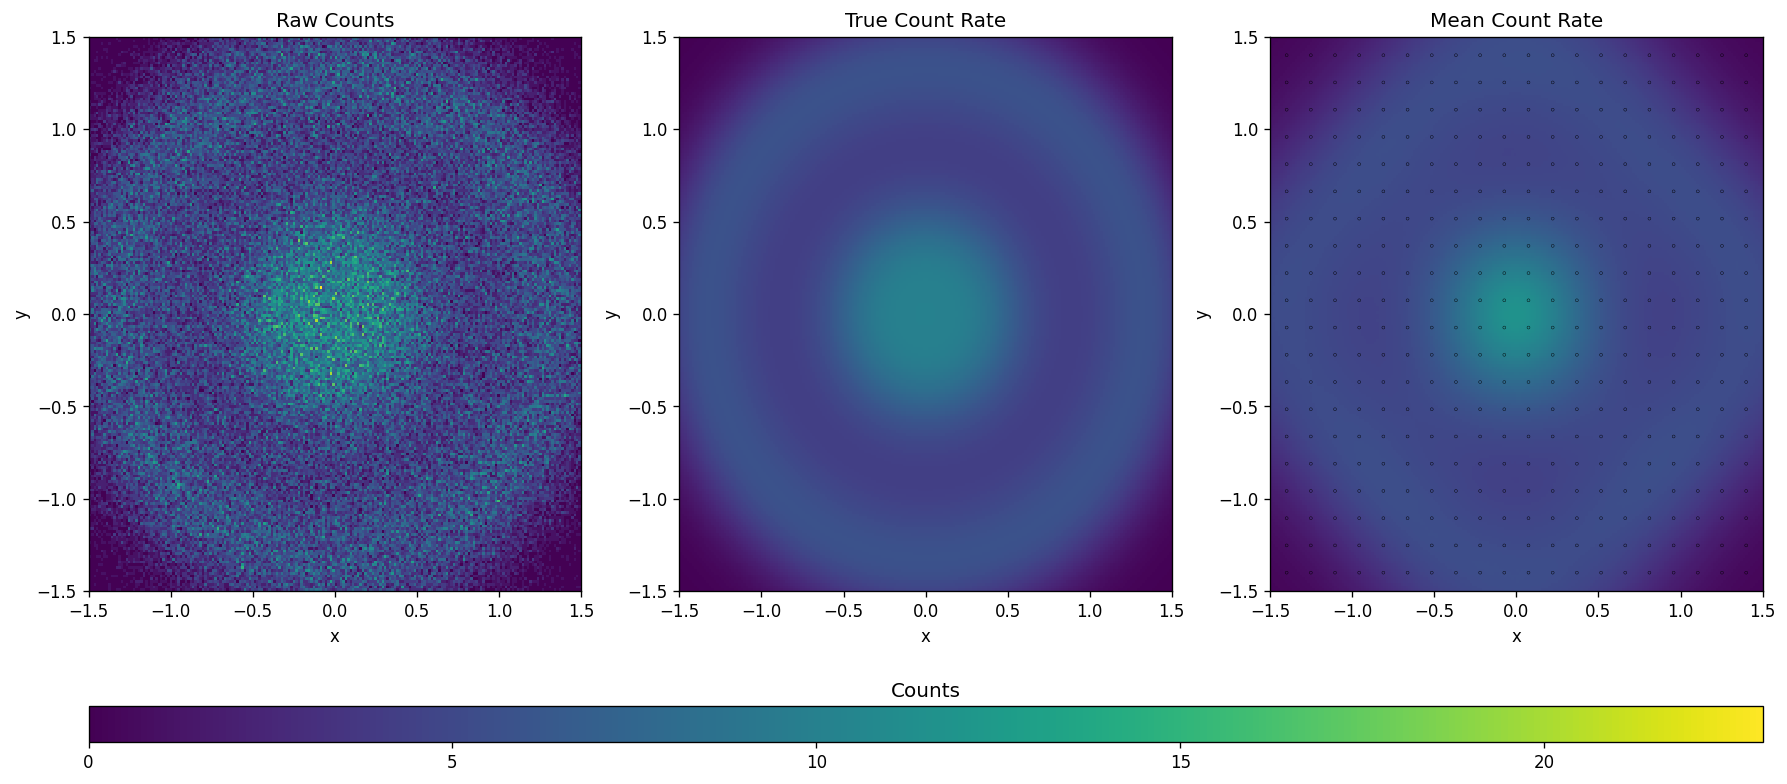

In [10]:
q = np.percentile(jnp.exp(gp_samples), [5,50,95], axis = 0)
q = q.reshape((3,x1_c.shape[0], x2_c.shape[0])).copy() # reshape to grid

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

import matplotlib as mpl

vmax = np.max([np.max(y_obs), np.max(y), np.max(jnp.exp(gp_samples))])
fig = plt.figure(figsize=(18, 6), dpi= 120)
ax1 = fig.add_subplot(131)
plot1 = plt.pcolormesh(x1_plt, x2_plt, y_obs, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax1.set_title('Raw Counts')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2 = fig.add_subplot(132)
plot2 = plt.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax2.set_title('True Count Rate')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3 = fig.add_subplot(133)
plot3 = plt.pcolormesh(x1_plt, x2_plt, q[1], cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax3.set_title('Mean Count Rate')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

p0 = ax1.get_position().get_points().flatten()
p1 = ax2.get_position().get_points().flatten()
p2 = ax3.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.1, p2[2]-p0[0], 0.05])

plt.colorbar(cax=ax_cbar, orientation='horizontal')
ax_cbar.set_title('Counts')

Text(0, 0.5, 'y')

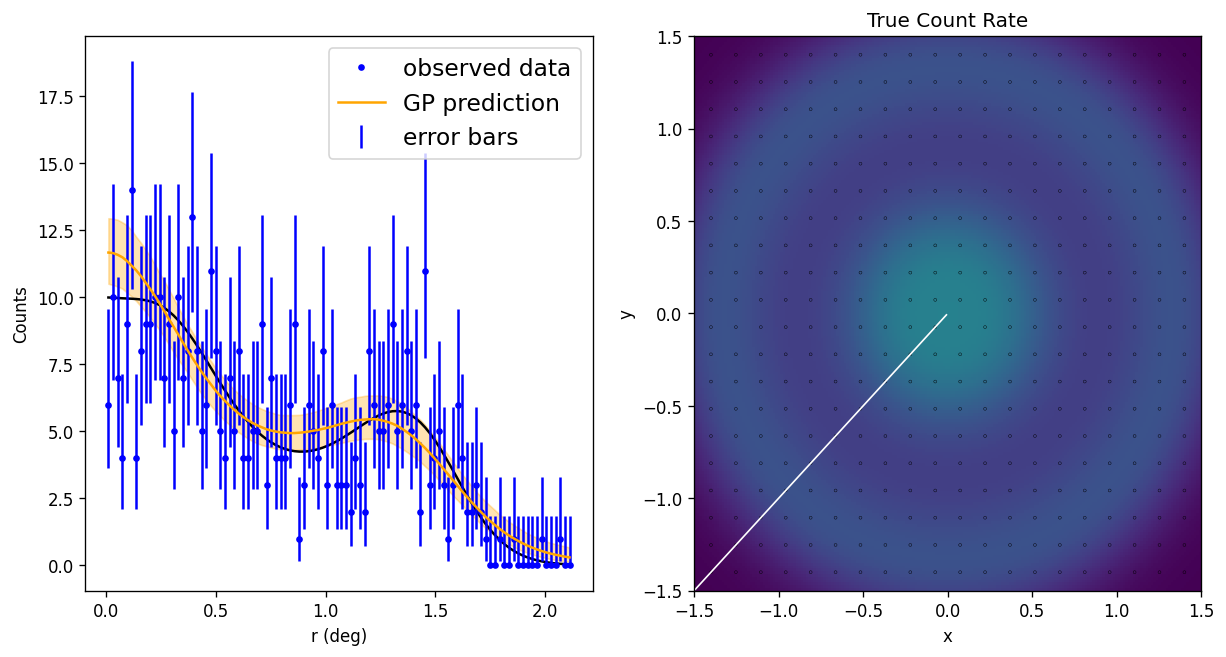

In [11]:
# Plot fit curves on a slice of increasing radius

fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(121)

Nx = len(x1_c)
ny = np.arange(0,int(Nx/2),1)
y = rate

r = np.linalg.norm(x[ny,ny,:], axis = -1)


ax.plot(r, y[ny,ny], c = 'k')
ax.plot(r, y_obs[ny,ny], 'b.', label='observed data')
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs[ny,ny].T]).T
ax.errorbar(r, y_obs[ny,ny], yerr = yerr, c = 'b', fmt = 'none', label='error bars')
ax.plot(r, q[1][ny,ny], c = 'orange', label = 'GP prediction')
ax.fill_between(r, q[0][ny,ny], q[2][ny,ny], color = 'orange', alpha = 0.3)
ax.set_xlabel('r (deg)')
ax.set_ylabel('Counts')
ax.legend(fontsize = 14)

ax = fig.add_subplot(122)

ax.pcolormesh(x1_plt, x2_plt, y, cmap='viridis',
             norm=mpl.colors.Normalize(vmin=0, vmax=vmax))
ax.plot(x[ny,ny,0], x[ny,ny,1], c = 'w', lw = 1)
ax.scatter(xu_f[:,0], xu_f[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)
ax.set_title('True Count Rate')
ax.set_xlabel('x')
ax.set_ylabel('y')

## Appendix A: Random Fourier Features for Sparse GP Sampling

### Random Fourier Features
Use spectral information of the kernel to simplify calculation [[1]]

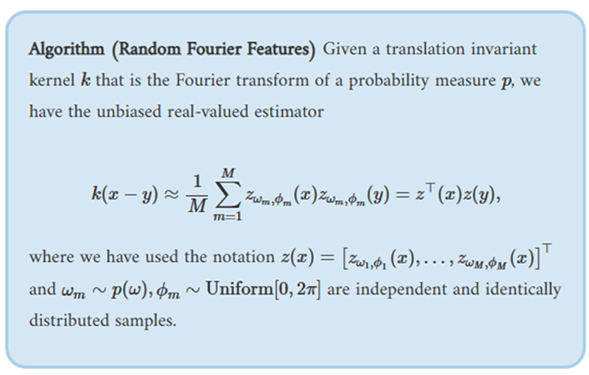

Then, the function can be approximated with

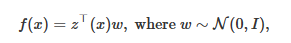

**Benefit:** Don't need the covariance matrix to load samples
**Issue:** We can’t use this with inducing points, as our posterior is a conditional GP (i.e., the kernel does not take a simple form where the RFF approach can be applied)

### Random Fourier Features with Pathwise Conditioning
To resolve this issue, we can use the following technique for sampling from a conditional Gaussian Process [[2]]:

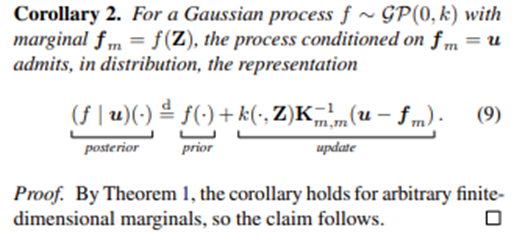

As it is, this pathwise conditioning is useless, since it requires us to sample from the whole $[f,u]$ GP anyways. However, with Random Fourier Features, we require much less memory to sample $f$. An RFF approach is proposed below (this was taken from somewhere, but I don't remember where).

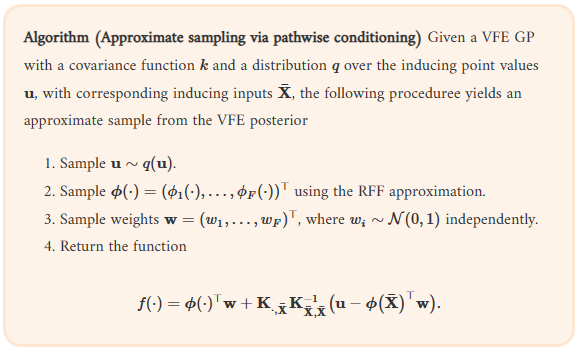

Therefore, we can generate approximate samples from our best-fit GPs by using this pathwise conditioning approach and replace the unconditioned GP with a set of RFFs. To be more precise, since we define our approximate posterior as $q(f) = \int du \ p(f|u) q(u)$, where $p(f|u)$ is an unconditioned zero-mean GP with a stationary kernel, we apply pathwise conditioning specifically when attempting to sample from our GP posterior over the entire input space. 

All this comes with the caveat that RFFs typically show less variance than the GP it attempts to approximate. [[3]]

As a final note, we can use this RFF-approach as an alternative to subsampling in our sparse GP fit. However, we are better off approximating the log-likelihood with subsampling than approximating the GP-prior samples themselves.

<!-- ### Reference: -->

[1]: <https://random-walks.org/book/papers/rff/rff.html> "Random Fourier features"
[2]: <https://arxiv.org/pdf/2002.09309> "Efficiently Sampling Functions from Gaussian Process Posteriors"
[3]: <https://random-walks.org/book/papers/rff/rff.html#variance-starvation> "Random Fourier features - Variance Starvation"